In [1]:
import numpy as np
from astropy import units as u
from astropy import constants as const
from matplotlib import pyplot as plt

from plotting import label_axes

# Synchrotron vs. Inverse Compton losses parity

Overall power emitted (i.e. energy lost by a particle) by both mechanisms is given by the same expression

$$
P = A_{proc} \frac{8 \pi e^4 U_{proc}}{3 m^2 c^3} \left( \frac{E}{m c^2} \right)^2
$$

Here $A_{proc}$ is a dimensionless scale and $U_{proc}$ is an energy density associated with a given EM process.

Namely, $A_{synch} = 1$, $U_{synch} = U_B = \frac{B_\perp^2}{4 \pi}$ and
$A_{IC} = \frac{4 \pi}{3}$, $U_{IC}$ is radiation field's energy density, for CMB given by Stefan-Boltzmann law: $U_{IC} = \frac{\sigma_{SB} T_{CMB}^4}{c}$

From this, we get that equal energy loss is obtained for magnetic field (assuming $B = B_\perp$, i.e. $\sin \theta = 1$)

$$
B = \sqrt{\frac{16 \pi^2}{3} \frac{\sigma_{SB} T_{CMB}^4}{c}}
$$


In [2]:
from utils import black_body_energy_density

In [3]:
T_CMB = 2.725 * u.K
U_CMB = black_body_energy_density(T_CMB)
n_CMB = (U_CMB / (const.k_B * T_CMB).to(u.eV)).to(u.cm ** (-3))
print(f"U_CMB = {U_CMB:.3f}\nn_CMB = {n_CMB:.3f}")

U_CMB = 0.065 eV / cm3
n_CMB = 277.209 1 / cm3


In [4]:
from utils import gauss_cgs

B_equiv = np.sqrt((16 * np.pi**2 / 3) * U_CMB).to(gauss_cgs)
print(f"B for CMB-IC-matched losses: {B_equiv.value:.2e} gauss")

B for CMB-IC-matched losses: 2.34e-06 gauss


Synchrotron energy loss timescale

$$
P(E) = A_{proc} \frac{8 \pi e^4 U_{proc}}{3 m^2 c^3} \left( \frac{E}{m c^2} \right)^2 \\
\tau = \frac{E}{P(E)} \propto E^{-1}
$$

In [5]:
from utils import energy_loss_rate

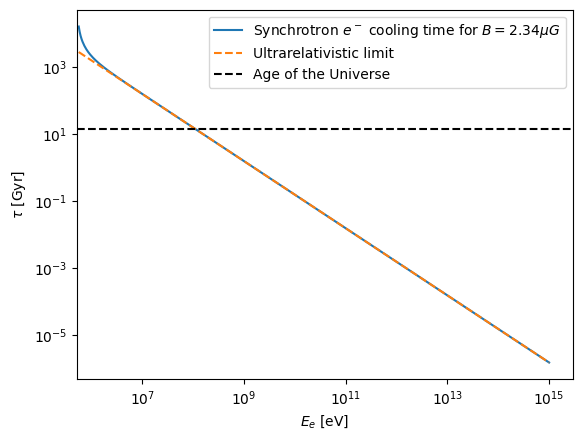

In [6]:
U_B_equiv = (B_equiv**2) / (4 * np.pi)

E_grid = np.logspace(np.log10(1.1 * 511e3), 15, 500, base=10) * u.eV
tau = (E_grid / energy_loss_rate(proc="synch", U=U_B_equiv, E=E_grid)).to(u.Gyr)
tau_ultrarelativistic = (
    E_grid / energy_loss_rate(proc="synch", U=U_B_equiv, E=E_grid, ultrarel_approx=True)
).to(u.Gyr)

fig, ax = plt.subplots()
ax.loglog(
    E_grid,
    tau,
    label=f"Synchrotron $e^-$ cooling time for $B = {B_equiv.value * 1e6:.2f} \\mu G$",
)
ax.loglog(
    E_grid,
    tau_ultrarelativistic,
    linestyle="--",
    label=f"Ultrarelativistic limit",
)
ax.axhline(13.787 * u.Gyr, color="k", linestyle="--", label="Age of the Universe")
ax.set_xlim(left=511e3 * u.eV)
label_axes(ax, "E_e", "\\tau")
ax.legend()
plt.show()

# Inverse Compton losses on Interstellar Radiation Field (ISRF)


scale = 3.87e-12
scale = 5.75e-09
scale = 2.61e-04


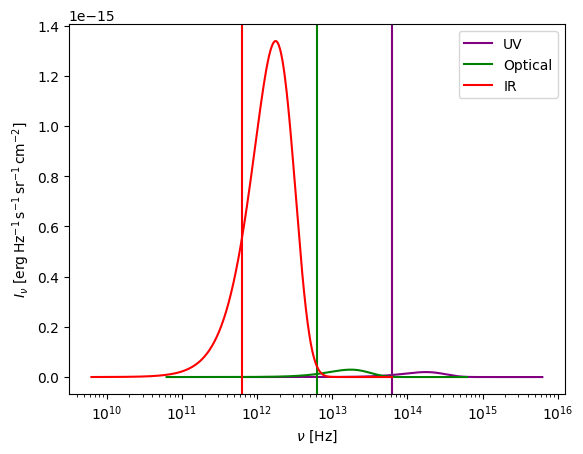

In [7]:
from astropy.modeling.physical_models import BlackBody


def grey_body(T: u.Quantity[u.K], rho: u.Quantity[u.eV / u.cm**3]) -> BlackBody:
    bb_rho = black_body_energy_density(T)
    scale = (rho / bb_rho).decompose()
    print(f"scale = {scale:.2e}")
    return BlackBody(temperature=T, scale=scale)


def energy_density(grey_body: BlackBody) -> u.Quantity[u.eV / u.cm**3]:
    return grey_body.scale.quantity * black_body_energy_density(
        T=grey_body.temperature.quantity
    )


ISRF_uv = grey_body(T=3000 * u.K, rho=0.37 * u.eV / u.cm**3)
ISRF_opt = grey_body(T=300 * u.K, rho=0.055 * u.eV / u.cm**3)
ISRF_ir = grey_body(T=30 * u.K, rho=0.25 * u.eV / u.cm**3)
ISRF_MODELS = (
    (ISRF_uv, "UV"),
    (ISRF_opt, "Optical"),
    (ISRF_ir, "IR"),
)

fig, ax = plt.subplots()

for (model, label), color in zip(ISRF_MODELS, ["purple", "green", "red"]):
    T = model.temperature.quantity
    nu_center = const.k_B * T / const.h
    nu_min = (nu_center * 1e-2).to(u.Hz)
    nu_max = (nu_center * 1e2).to(u.Hz)
    nu_grid = np.logspace(np.log10(nu_min.value), np.log10(nu_max.value), 500) * u.Hz
    ax.plot(nu_grid, model(nu_grid), label=label, color=color)
    ax.axvline(nu_center, color=color)
    # ax.axvline(T * (5.879e10 * (u.Hz / u.K)), color=color, linestyle="--")

ax.legend()
ax.set_xscale("log")
label_axes(ax, "\\nu", "I_\\nu")
plt.show()

In the low-energy regime (Thomson limit) when the pre-scattering photon energy in the electron's rest frame is $\epsilon^\prime_i \ll mc^2$, the energy loss rate is simply $P = \sigma_T c U_{rad}$

In [8]:
for model, name in ISRF_MODELS:
    U_rad = energy_density(model)
    P_IC = (const.sigma_T * const.c * U_rad).to(u.erg / u.s)
    print(f"{name}\nU_rad = {U_rad}\nP_IC = {P_IC:.2e}\n")

UV
U_rad = 0.37 eV / cm3
P_IC = 1.18e-26 erg / s

Optical
U_rad = 0.055 eV / cm3
P_IC = 1.76e-27 erg / s

IR
U_rad = 0.25 eV / cm3
P_IC = 7.99e-27 erg / s



# Thomson $\to$ Klein-Nishina transition

Thomson / KN regime is defined by $\epsilon^\prime_i = \gamma \epsilon_i$ w.r.t. electron rest mass $m_e c^2$. Hence, the transition happens for electrons with

$$
\gamma = \frac{E_e}{m_e c^2} = \frac{m_e c^2}{\epsilon_i} \\
E_e = \frac{m_e^2 c^4}{\epsilon_i} \\
E_e = \frac{m_e^2 c^4}{k_B T} 
$$



In [9]:
print("Thomson -> KN transition for electrons at energies")
for model, name in ISRF_MODELS:
    E_e_transition = (
        const.m_e**2 * const.c**4 / (const.k_B * model.temperature.quantity)
    ).to(u.TeV)
    print(f"{name}: E = {E_e_transition:.2f}")

Thomson -> KN transition for electrons at energies
UV: E = 1.01 TeV
Optical: E = 10.10 TeV
IR: E = 101.01 TeV


# Maximum diffuse distance with losses

Diffusion process results in electron moving to $L = \sqrt{D \tau}$ during time $\tau$.

$D$ under Bohm diffusion is:

$$
D = \frac 1 3 \lambda_{\mathrm{m.f.p.}} v = \frac 1 3 r_g c \\
r_g = \frac{v_\perp}{\omega_B} = \gamma \frac{v m c}{e B} = \frac{pc}{eB} = \frac{\sqrt{E^2 - m_e^2 c^4}}{eB}
$$

Diffusion time $\tau$ is determined by characteristic loss time $\tau = \frac{E}{P(E)}$

In the ultrarelativistic regime we write

$$
D = \frac{cE}{3eB} \\
\tau_{proc} = \frac{E}{P_{proc}(E)}  = \frac{3 m^4 c^7}{A_{proc} 8 \pi e^4 U_{proc}} E^{-1} \\
L_{proc} = \frac{(m c^2)^2}{\sqrt{e B A_{proc} 8 \pi e^4 U_{proc}}} = \mathrm{Const}(E)
$$


In [11]:
from utils import ENERGY_LOSS_SCALE_IC as A_IC

B = 3e-6 * gauss_cgs
U_B = (B**2 / (4 * np.pi)).to(u.eV / u.cm ** 3)
U_rad = sum(energy_density(model) for model, _ in ISRF_MODELS)

range_limit_synch = (const.m_e * const.c**2) ** 2 / np.sqrt(
    const.e.gauss * B * 8 * np.pi * const.e.gauss**4 * U_B
)
print("Ultrarel. limit of diffusion range")

print(f"Under only synch. losses L = {range_limit_synch.to(u.pc):.3f}")

range_limit_ic = (const.m_e * const.c**2) ** 2 / np.sqrt(
    const.e.gauss * B * A_IC * 8 * np.pi * const.e.gauss**4 * U_rad
)

print(f"... and IC losses L = {range_limit_ic.to(u.pc):.3f}")

range_limit = (const.m_e * const.c**2) ** 2 / np.sqrt(
    const.e.gauss * B * 8 * np.pi * const.e.gauss**4 * (U_B + A_IC * U_rad)
)

print(f"combined L = {range_limit.to(u.pc):.3f}")

Ultrarel. limit of diffusion range
Under only synch. losses L = 5.846 pc
... and IC losses L = 2.325 pc
combined L = 2.160 pc


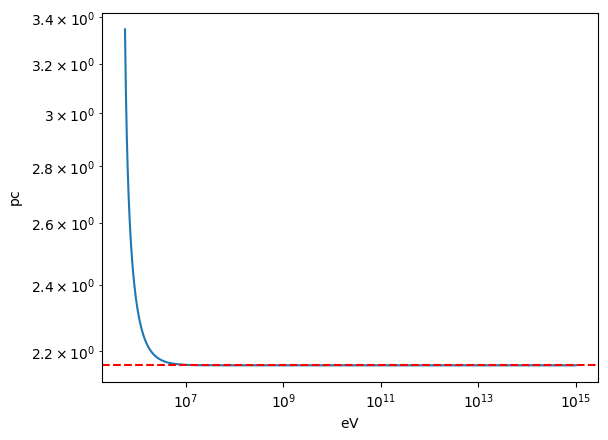

In [12]:
from utils import bohm_diffusion_coeff


D = bohm_diffusion_coeff(E_grid, B=B)

P_total = energy_loss_rate(
    proc="synch",
    U=U_B,
    E=E_grid,
) + energy_loss_rate(
    proc="ic",
    U=sum(energy_density(model) for model, _ in ISRF_MODELS),
    E=E_grid,
)
tau_total = E_grid / P_total

diffusion_range = np.sqrt(D * tau_total).to(u.pc)

fig, ax = plt.subplots()
ax.loglog(E_grid, diffusion_range)
ax.axhline(range_limit, color="red", linestyle="--")
plt.show()

Takeaway - to observe electrons at $O(\mathrm{kpc})$ distances from Galactic disk, we need non-Bohm diffusion yielding $10^6$ larger $D$